# Advanced lane lines

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

### [function] Resize Images

In [104]:
def resizeImage(image,shape=(1280,720)):
    """
    image should be a np.array image, note that it will be modified
    """
    ysize = image.shape[0]
    xsize = image.shape[1]

    # Resize image if necesaary
    if xsize != shape[0] and ysize != shape[1]:
        image = cv2.resize(image, (shape[0], shape[1]),)

    return image

### [function] Display a list of images

In [105]:
def displayListImages(images,titles=[],cols=1,cmap=None, figSize = [12,12]):
    """
    Function to display and resize a list of images
    images is a list of matplotlib image (use imread)
    titles is a list of strings
    cols is an integer with the number of columns to display
    rows is an integer with the number of rows to display
    """
    rows = len(images)//cols
    if len(cal_images)%cols > 0:
        rows+=1

    # Helper to adapt images to full width
    plt.rcParams['figure.figsize'] = [figSize[0], figSize[1]*cols]
    plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

    for i in range(len(images)):
        
        plt.subplot(rows, cols, i+1)
        
        image = resizeImage(images[i])
        if titles:
            plt.title(titles[i]) 
        plt.imshow(image, cmap=cmap, aspect='auto')

        
#Test function
#displayListImages(cal_images,cols=2)

## Camera distortion calibration
### Find chessboards  on images

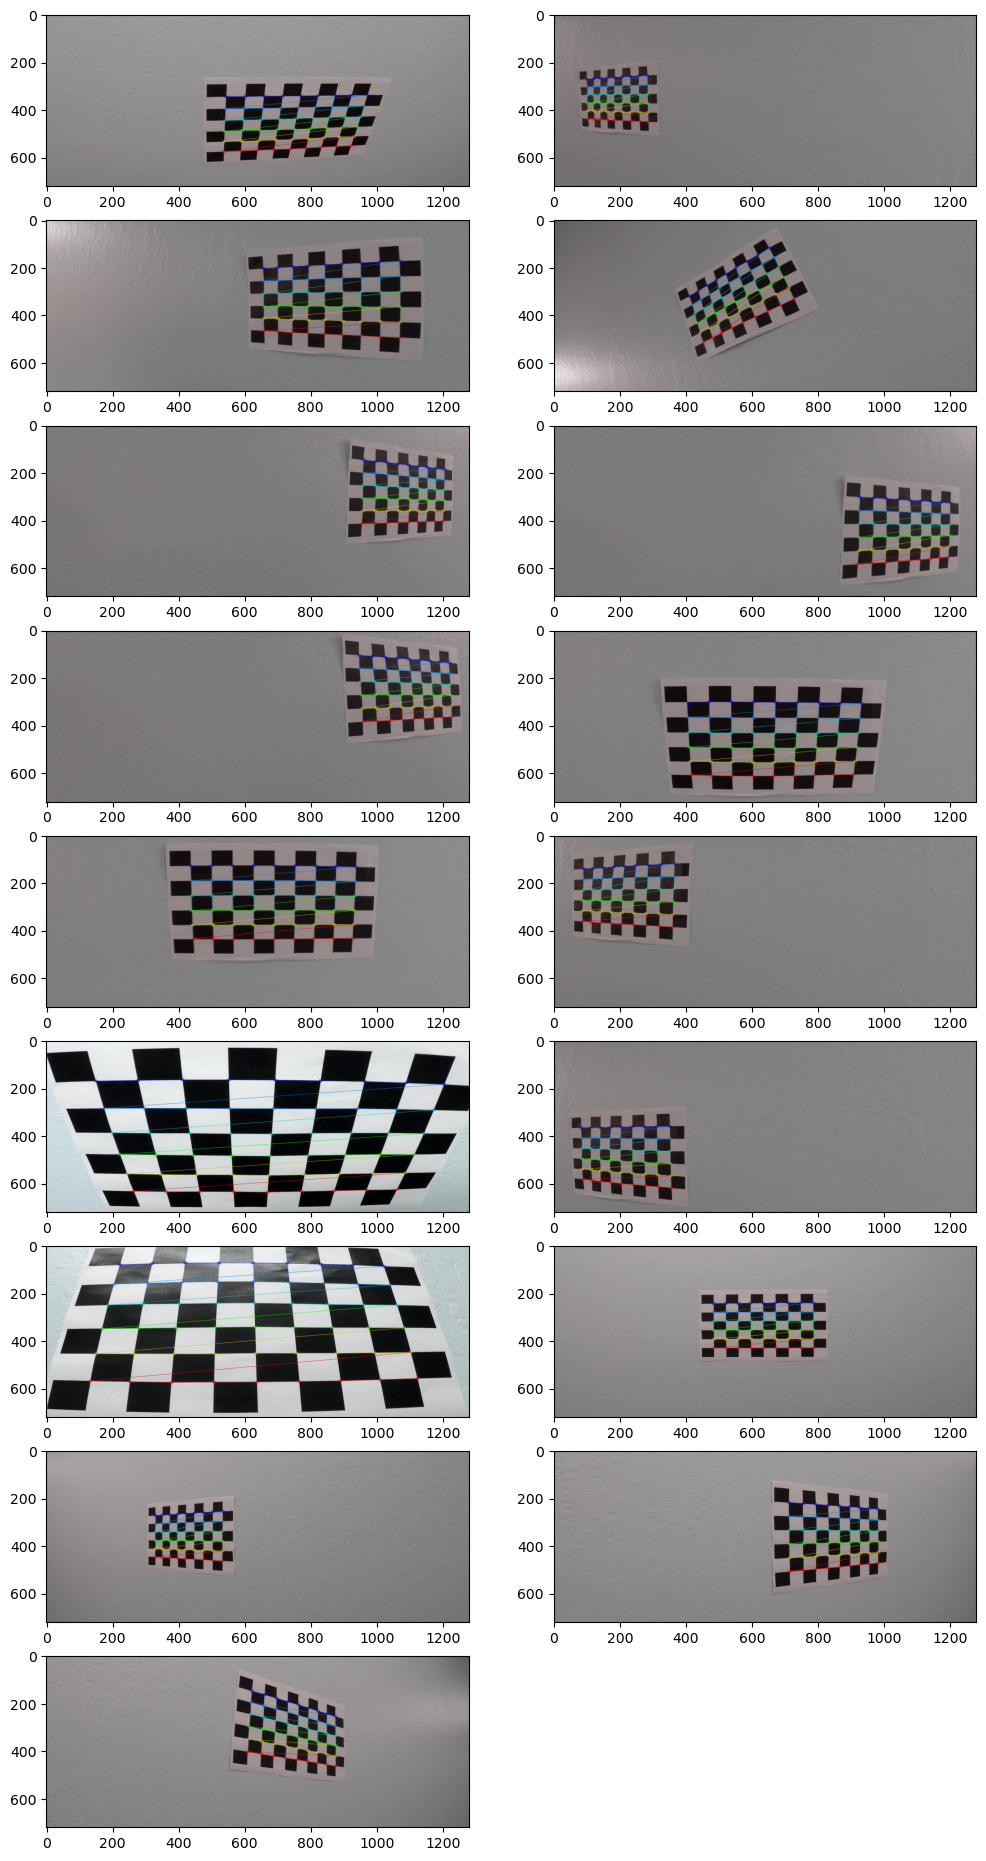

In [106]:
chessGrid = [9,6]
cal_images =  [];

imageResolution = [720,1280]

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((np.prod(chessGrid),3), np.float32)
objp[:,:2] = np.mgrid[0:chessGrid[0], 0:chessGrid[1]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (chessGrid[0],chessGrid[1]), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        cal_images.append(img)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (chessGrid[0],chessGrid[1]), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

displayListImages(cal_images,cols=2)

In [107]:
## Find camera calibration parameters
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, tuple(imageResolution), None,None)

## Undistort images

### [function] Undistort images

In [108]:
def undistort_image(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

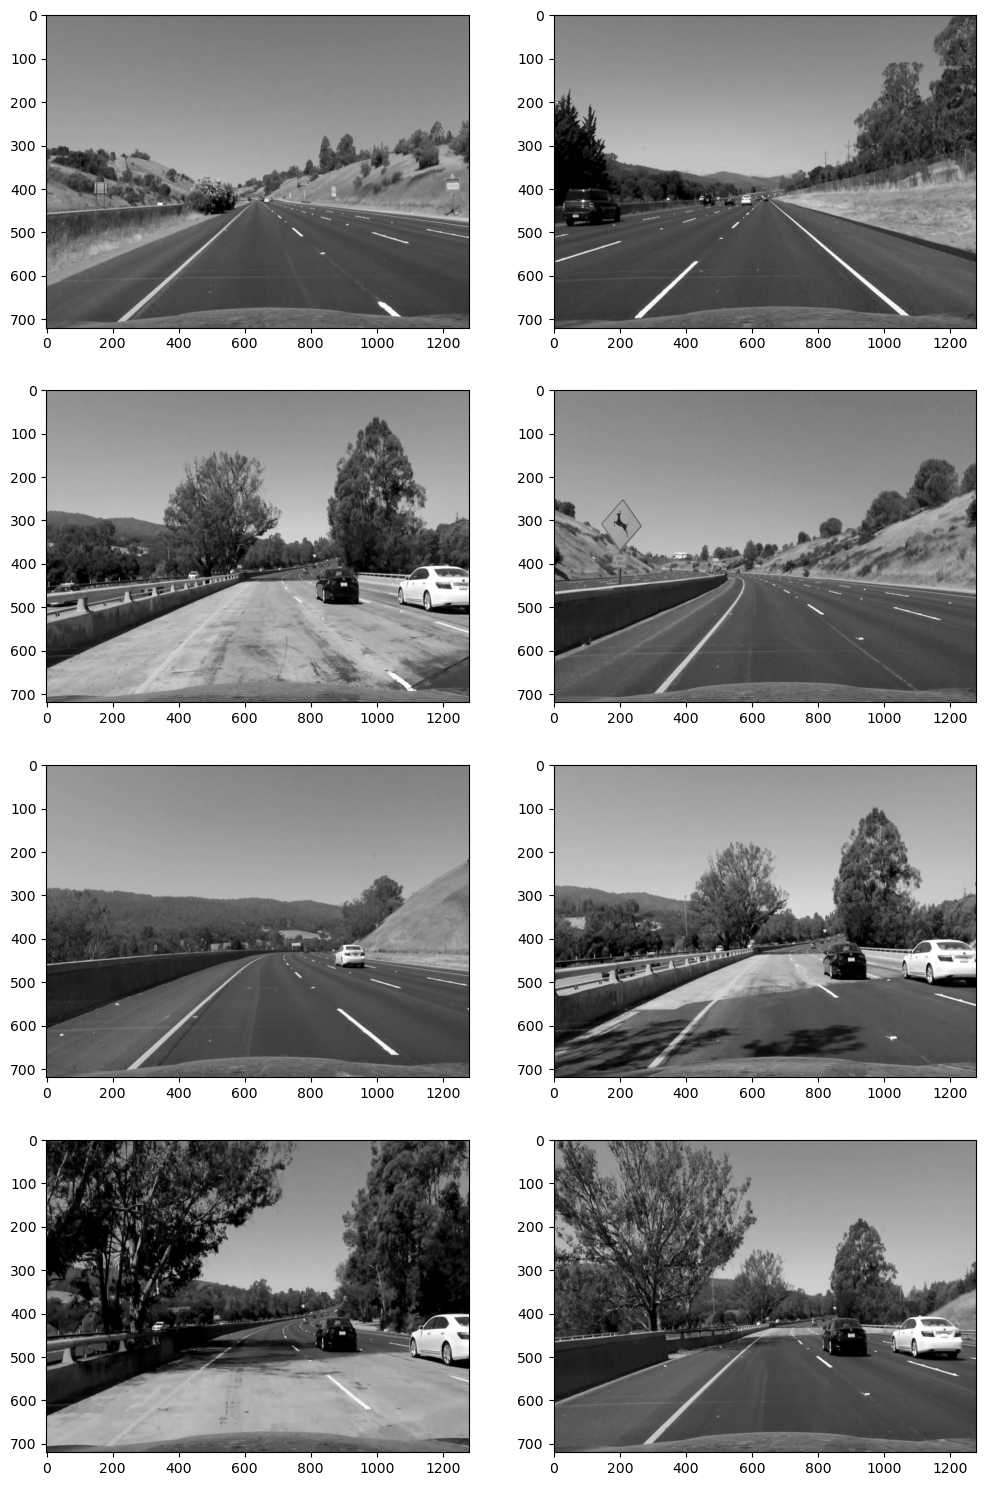

In [109]:
# Read test images
images = glob.glob('test_images/*.jpg')
test_images =  [];
und_images = []

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    test_images.append(gray)
    
    undistorted = undistort_image(test_images[idx], mtx, dist)
    und_images.append(undistorted)
        
displayListImages(und_images,cols=2,cmap='gray',)

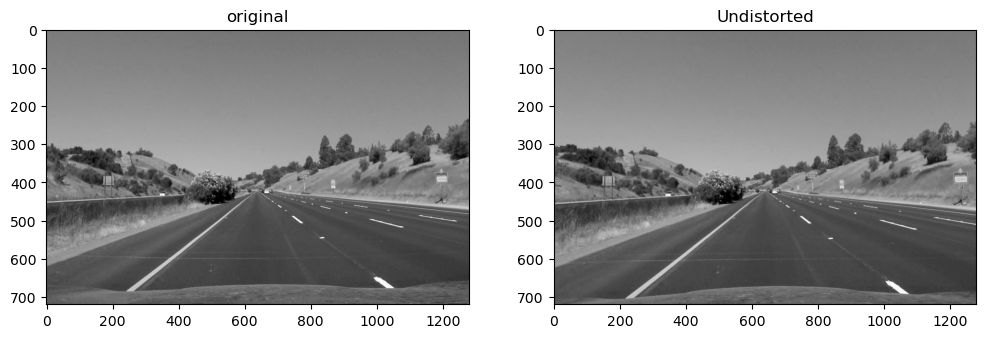

In [110]:
original = test_images[0]
undistorted_straight = undistort_image(original, mtx, dist)
displayListImages([original,undistorted_straight],cols=2,cmap='gray',figSize=[12,4],titles = ['original','Undistorted'])

## Wrap Images

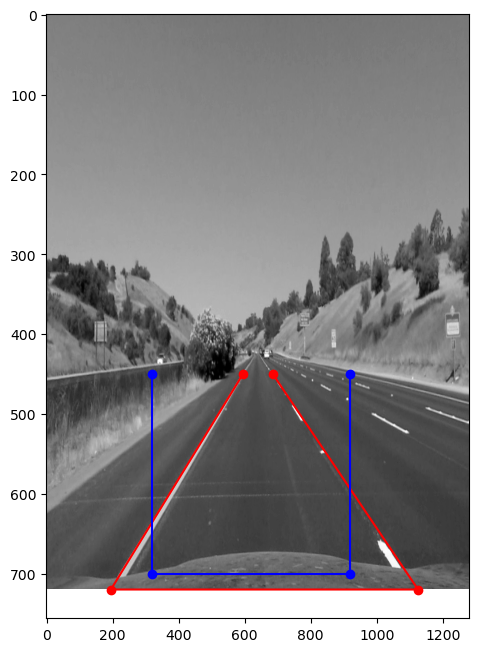

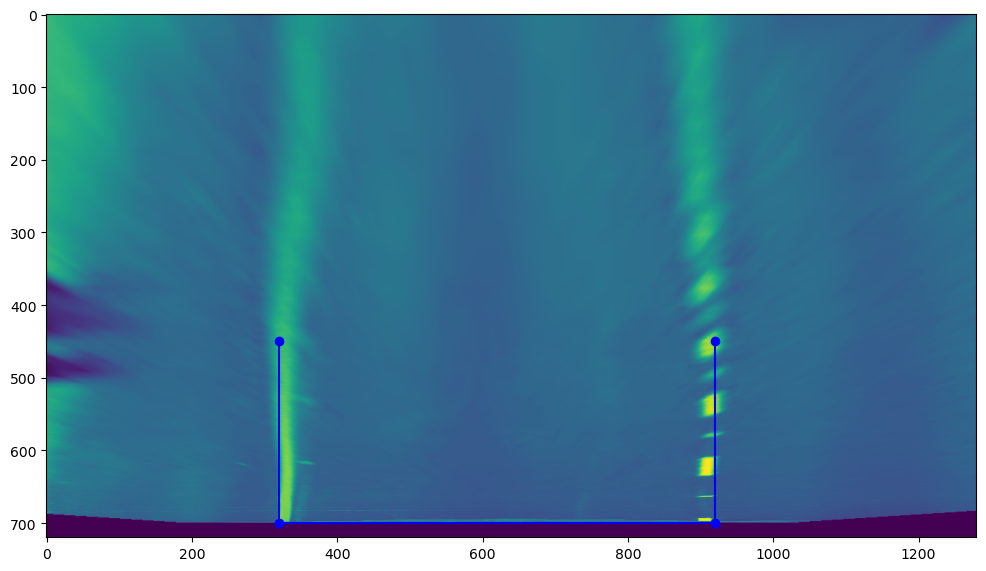

In [163]:
img = undistorted_straight
displayListImages([img],cols=2,cmap='gray',figSize=[12,4])

#Source
# Place source points for uimage wrapping
dotS_UL=[595,450]; dotS_UR= [685,450]
dotS_LL=[195,720] ; dotS_LR= [1125,720]

src= np.float32([dotS_UL,dotS_LL,dotS_LR,dotS_UR])

# Create and plot source plane
xs = [x[0] for x in src]
ys = [x[1] for x in src]

plt.plot(xs,ys, 'ro-')

#Destination
hwidth = 300
offset = -20
dotD_UL=[offset+(1280//2)-hwidth,450]; dotD_UR= [offset+(1280//2)+hwidth,450]
dotD_LL=[offset+(1280//2)-hwidth,700] ; dotD_LR= [offset+(1280//2)+hwidth,700]

dst= np.float32([dotD_UL,dotD_LL,dotD_LR,dotD_UR])

xd = [x[0] for x in dst]
yd = [x[1] for x in dst]

plt.plot(xd,yd, 'bo-')

# Create and plot source plane
xd = [x[0] for x in dst]
yd = [x[1] for x in dst]

#Computye perspective transform
M = cv2.getPerspectiveTransform(src, dst)

warped = cv2.warpPerspective(img, M, (1280,720), flags=cv2.INTER_LINEAR)

plt.figure()
plt.imshow(warped)
plt.plot(xd,yd, 'bo-')